https://keras.io/examples/generative/conditional_gan/

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

2023-07-24 13:07:55.679536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 13:07:56.237185: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.pyplot as plt

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [4]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

2023-07-24 13:07:57.431552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 13:07:57.445928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-24 13:07:57.446100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [5]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [6]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [7]:
class WCGAN(keras.Model):
    
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, one_hot_labels = data


        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

        batch_size = tf.shape(real_images)[0]
        
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_labels = tf.concat(
                [random_latent_vectors, one_hot_labels], axis=1
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_vector_labels)
                fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
                fake_logits = self.discriminator(fake_image_and_labels)
                real_logits = self.discriminator(real_image_and_labels)
                
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_image_and_labels, fake_image_and_labels)
                
                d_loss = d_cost + gp * self.gp_weight

        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        
        self.d_optimizer.apply_gradients(
            zip(d_gradient, self.discriminator.trainable_variables)
        )
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(fake_image_and_labels)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)
        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='d_loss', patience=3)

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for training.
epochs = 20

# Get the wgan model
wgan = WCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=5,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(dataset, batch_size=batch_size, epochs=epochs, callbacks=early_stop)

Epoch 1/20
1094/1094 [==============================] - 21s 17ms/step - d_loss: -0.0610 - g_loss: -0.7585
Epoch 2/20
1094/1094 [==============================] - 18s 16ms/step - d_loss: -0.0614 - g_loss: -0.6325
Epoch 3/20
1094/1094 [==============================] - 19s 17ms/step - d_loss: -0.0613 - g_loss: -0.6167
Epoch 4/20
1094/1094 [==============================] - 18s 17ms/step - d_loss: -0.0609 - g_loss: -0.5539
Epoch 5/20
1094/1094 [==============================] - 18s 17ms/step - d_loss: -0.0604 - g_loss: -0.3996
Epoch 6/20
1094/1094 [==============================] - 15s 14ms/step - d_loss: -0.0594 - g_loss: -0.4706
Epoch 7/20
1094/1094 [==============================] - 17s 15ms/step - d_loss: -0.0596 - g_loss: -0.3989
Epoch 8/20
1094/1094 [==============================] - 16s 14ms/step - d_loss: -0.0551 - g_loss: -0.4836
Epoch 9/20
1094/1094 [==============================] - 15s 14ms/step - d_loss: -0.0541 - g_loss: -0.4590


In [42]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        6400      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Glob  (None, 128)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                     

In [67]:
interpolation_noise = tf.random.normal(shape=(1, latent_dim))

In [68]:
first_label = keras.utils.to_categorical([3], num_classes)

In [69]:
noise_and_labels = tf.concat([interpolation_noise, first_label], 1)

In [70]:
trained_gen = wgan.generator
fake = trained_gen.predict(noise_and_labels)

1/1 [==============================] - 0s 14ms/step


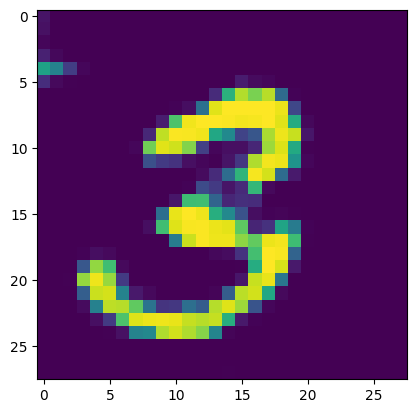

In [71]:
plt.imshow(tf.reshape(fake, (28,28)))